O serviço de vendas de carros usados Rusty Bargain está desenvolvendo um aplicativo para atrair novos clientes. Nesse aplicativo, você pode descobrir rapidamente o valor de mercado do seu carro. Você tem acesso a dados históricos: especificações técnicas, versões de acabamento e preços. Você precisa construir o modelo para determinar o valor. 

Rusty Bargain está interessado em:

- a qualidade da predição;
- a velocidade da predição;
- o tempo necessário para o treinamento

## Imports e Configs Iniciais

In [155]:
# importando as bilbliotecas necessárias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
import re
from plotly.subplots import make_subplots

#importando Modelos de ML
import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore') # para ignorar os warnings do sklearn
from IPython.display import display # para mostrar o dataset de forma mais legível
pd.set_option('display.max_columns', None) # para mostrar todas as colunas do dataset



## 📖 Dicionário de Dados: Rusty Bargain

| Coluna (no arquivo) | Nome sugerido (snake_case) | O que representa |
|---|---|---|
| DateCrawled  | date_crawled | Data em que o perfil foi baixado do banco de dados. |
| Price | price |  **Alvo**: preço (Euro). |
| VehicleType | vehicle_type | Tipo de carroçaria do veículo. |
| RegistrationYear | registration_year | Ano de Fabricação do veículo. |
| Gearbox | gearbox | Tipo de caixa de transmissão. |
| Power | power | Potência (hp). |
| Model | model | Modelo do veículo. |
| Mileage | mileage | quilometragem (medida em km). |
| RegistrationMonth | registration_month | Mês de registro do veículo. |
| FuelType | fuel_type | Tipo de combustível. |
| Brand | brand | marca do veículo. |
| NotRepaired | not_repaired | Veículo reparado ou não. |
| DateCreated	 | date_created | Data de criação do perfil. |
| NumberOfPictures | number_of_pictores | Número de fotos do veículo. |
| PostalCode | postal_code | Código postal do proprietário do perfil (usuário). |
|LastSeen | last_seen | Data da última atividade do usuário. |


## Carregamento dos Dados

In [156]:
# importando o dataset
df = pd.read_csv('car_data.zip')

# visualizando as primeiras linhas do dataset
df.head() 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


## Pré-Processamento

In [157]:
# Função para transformar nomes em snake_case
def to_snake_case(col_name: str) -> str:
    """
    Converte um nome de coluna para snake_case:
    - remove espaços extras
    - troca espaços e hífens por underscore
    - remove caracteres especiais
    - converte para minúsculas
    """
    col_name = re.sub(r'([a-z])([A-Z])', r'\1_\2', col_name) # adiciona "_" entre letras minúsculas seguidas de maiúsculas
    col_name = col_name.strip().lower()             # remove espaços nas pontas e coloca em minúsculas
    col_name = re.sub(r"[\s\-]+", "_", col_name)    # troca espaços e hífens por "_"
    col_name = re.sub(r"[^a-z0-9_]", "", col_name)  # remove caracteres que não são letras, números ou "_"
    col_name = re.sub(r"_+", "_", col_name)         # evita múltiplos "_" seguidos
    
    return col_name

In [158]:
[to_snake_case(col) for col in df.columns]

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'mileage',
 'registration_month',
 'fuel_type',
 'brand',
 'not_repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

In [159]:
# Aplicar a função em todas as colunas
df.columns = [to_snake_case(col) for col in df.columns]

# Conferir resultado
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [160]:
df.duplicated().sum()   

np.int64(262)

In [161]:
#removendo as duplicatas
df.drop_duplicates(inplace=True)
#verificando se as duplicatas foram removidas
df.duplicated().sum()

np.int64(0)

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354107 non-null  object
 1   price               354107 non-null  int64 
 2   vehicle_type        316623 non-null  object
 3   registration_year   354107 non-null  int64 
 4   gearbox             334277 non-null  object
 5   power               354107 non-null  int64 
 6   model               334406 non-null  object
 7   mileage             354107 non-null  int64 
 8   registration_month  354107 non-null  int64 
 9   fuel_type           321218 non-null  object
 10  brand               354107 non-null  object
 11  not_repaired        282962 non-null  object
 12  date_created        354107 non-null  object
 13  number_of_pictures  354107 non-null  int64 
 14  postal_code         354107 non-null  int64 
 15  last_seen           354107 non-null  object
dtypes: int6

## EDA

Analisar as váriaveis catégoricas: - vehicle_type | gearbox | model | fuel_type | brand | not_repaired

In [172]:
df_vehicle_type = df['vehicle_type'].unique()
display(df_vehicle_type)
print(100*'-')
print("Quantidade de ausentes:", df['vehicle_type'].isna().sum(), "| Porcentagem de ausentes: {:.1f}%".format((df['vehicle_type'].isna().sum()/len(df))*100))

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

----------------------------------------------------------------------------------------------------
Quantidade de ausentes: 37484 | Porcentagem de ausentes: 10.6%


In [173]:
df_gearbox = df['gearbox'].unique()
print(df_gearbox)
print(100*'-')
print("Quantidade de ausentes:", df['gearbox'].isna().sum(), "| Porcentagem de ausentes: {:.1f}%".format((df['gearbox'].isna().sum()/len(df))*100))

['manual' 'auto' nan]
----------------------------------------------------------------------------------------------------
Quantidade de ausentes: 19830 | Porcentagem de ausentes: 5.6%


Novamente um forte desbalanceamento de classes, seria mais dificil um modelo identificar e precificar o carro com cambio automatico.

In [174]:
df_model = df['model'].unique()
print(df_model)
print(100*'-')
print('Quantidade de modelos unicos:', len(df_model))
print(100*'-')
print("Quantidade de ausentes:", df['model'].isna().sum(), "| Porcentagem de ausentes: {:.1f}%".format((df['model'].isna().sum()/len(df))*100))

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

In [175]:
df_fuel_type = df['fuel_type'].unique()
print(df_fuel_type)
print(100*'-')
print("Quantidade de ausentes:", df['fuel_type'].isna().sum(), "| Porcentagem de ausentes: {:.1f}%".format((df['fuel_type'].isna().sum()/len(df))*100))

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
----------------------------------------------------------------------------------------------------
Quantidade de ausentes: 32889 | Porcentagem de ausentes: 9.3%


In [176]:
df_brand = df['brand'].unique()
print(df_brand)
print(100*'-')
print('Quantidade de marcas unicas:', len(df_brand))
print(100*'-')
print("Quantidade de ausentes:", df['brand'].isna().sum(), "| Porcentagem de ausentes: {:.1f}%".format((df['brand'].isna().sum()/len(df))*100))

['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']
----------------------------------------------------------------------------------------------------
Quantidade de marcas unicas: 40
----------------------------------------------------------------------------------------------------
Quantidade de ausentes: 0 | Porcentagem de ausentes: 0.0%


In [177]:
df_not_repaired = df['not_repaired'].unique()
print(df_not_repaired)
print(100*'-')
print("Quantidade de ausentes:", df['not_repaired'].isna().sum(), "| Porcentagem de ausentes: {:.1f}%".format((df['not_repaired'].isna().sum()/len(df))*100))

[nan 'yes' 'no']
----------------------------------------------------------------------------------------------------
Quantidade de ausentes: 71145 | Porcentagem de ausentes: 20.1%


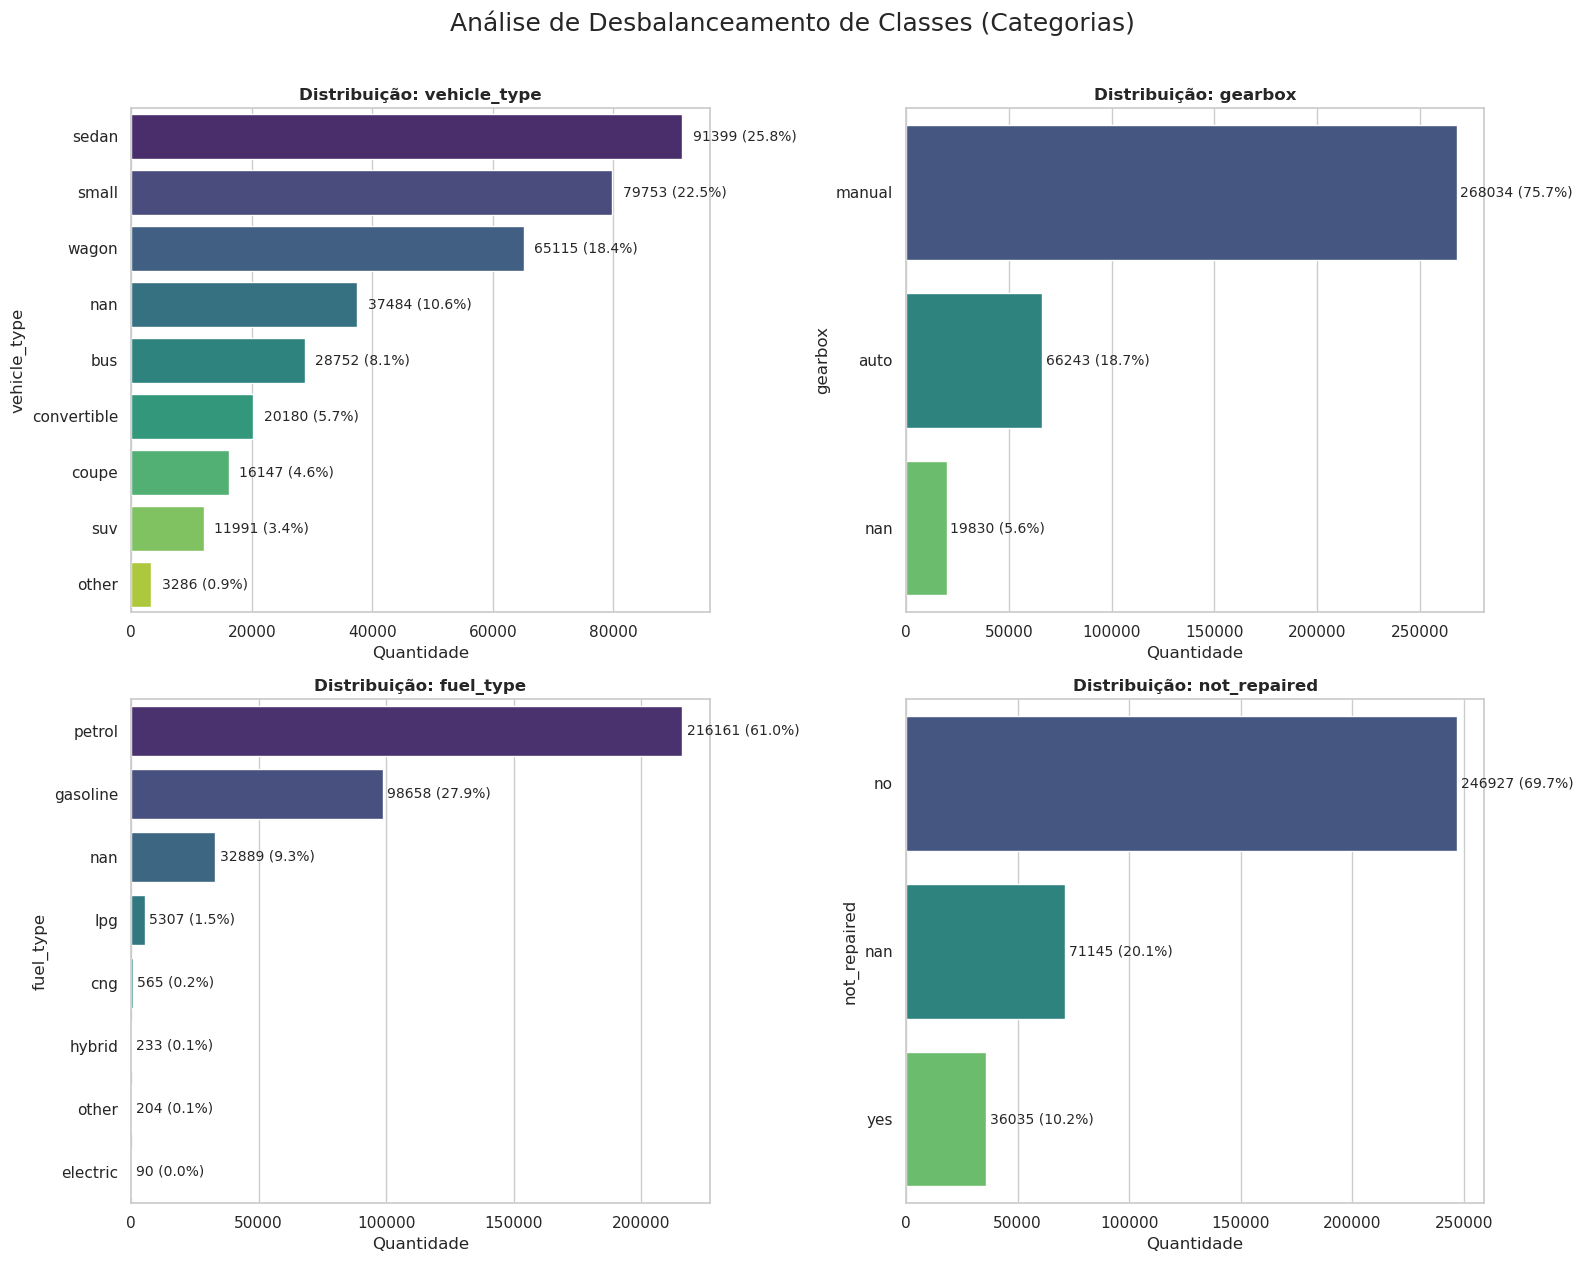

In [169]:

# 1. Definimos as colunas categóricas que queremos analisar
# (Ajustei para as principais, removendo 'model' que é grande demais para grade)
cat_features = ['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']

# 2. Configuramos o layout da grade (ex: 2 linhas e 2 colunas)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten() # Transforma a matriz de eixos em uma lista simples para o loop
total_rows = len(df)

# 3. Loop para criar cada gráfico
for i, col in enumerate(cat_features):
    # Contagem incluindo nulos
    counts = df[col].value_counts(dropna=False)
    
    # Plot no eixo correspondente (axes[i])
    sns.barplot(x=counts.values, y=counts.index.astype(str), ax=axes[i], palette='viridis')
    
    # Título de cada subplot
    axes[i].set_title(f'Distribuição: {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Quantidade')
    
    # Adicionando as porcentagens nas barras
    for j, v in enumerate(counts.values):
        perc = (v / total_rows) * 100
        axes[i].text(v + (total_rows * 0.005), j, f'{v} ({perc:.1f}%)', va='center', fontsize=10)

# 4. Ajustes finos de layout para não sobrepor nada
plt.tight_layout()
plt.suptitle('Análise de Desbalanceamento de Classes (Categorias)', fontsize=18, y=1.05)
plt.show()

Das variáveis categóricas, temos problemas como: Alta cardinalidade (brand e model), desbalanceamento de classes nas demais. Além dos valores ausentes que será preciso definir ainda o que fazer.

# Correção das inconsistências nas variáveis categóricas 


In [179]:
# ============================================================
# ETAPA: Limpeza e Tratamento de Nulos (Categorias)
# ============================================================


# 1. Tratando valores ausentes nas colunas categóricas
# Substituímos NaN por 'unknown' para manter a integridade dos dados
df_cleaned = df.copy()

cat_cols_with_nan = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired', 'brand']

for col in cat_cols_with_nan:
    df_cleaned[col] = df_cleaned[col].fillna('unknown')

# 2. Verificação final de nulos
print("Valores ausentes por coluna após o tratamento:")
print(df_cleaned.isnull().sum())

# 3. Resetando o index (importante após filtros de linhas)
df_cleaned = df_cleaned.reset_index(drop=True)



Valores ausentes por coluna após o tratamento:
date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64


# Análise das variáveis numéricas

Variáveis númericas : power | mileage | registration_year  (todas sem problemas de nulos)

In [181]:
#variavel power - potência em hp
df_power = df['power'].unique() 
print(df_power)

[    0   190   163    75    69   102   109    50   125   101   105   140
   115   131    60   136   160   231    90   118   193    99   113   218
   122   129    70   306    95    61   177    80   170    55   143    64
   286   232   150   156    82   155    54   185    87   180    86    84
   224   235   200   178   265    77   110   144   120   116   184   126
   204    88   194   305   197   179   250    45   313    41   165    98
   130   114   211    56   201   213    58   107    83   174   100   220
    85    73   192    68    66   299    74    52   147    65   310    71
    97   239   203     5   300   103   258   320    63    81   148    44
   145   230   280   260   104   188   333   186   117   141    59   132
   234   158    39    92    51   135    53   209    43   146    67   106
   166   276   344    72   249   237   245   111   326   279    23   138
   175    96   226    26    37   301   334   128   133   124    33   219
   241   167    94   182   196   238  1398   228   

No quesito potencia, o que levar em consideração? há potências muito baixas e outras muitos altas, indicando carros esportivos?. Desconsiderar esses dadoos? Tem potencias baixas demais, indicando erro de digitação 

In [149]:
# variavel mileage - quilometragem do carro
df_mileage = df['mileage'].unique()
print(df_mileage)   

[150000 125000  90000  40000  30000  70000   5000 100000  60000  20000
  80000  50000  10000]


In [150]:
df_registration_year = df['registration_year'].unique()
print(df_registration_year) 
print(100*'-')
print("menor ano encontrado:", df_registration_year.min(), "| maior ano encontrado:", df_registration_year.max())

[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]
----------------------------------------------------------------------------------------------------
menor ano encontrado: 1000 | maior ano encontrado: 9999


Observe que constam anos impossíveis, como 7100, 1111, etc. Farei um filtro para buscar a realidade das informações.

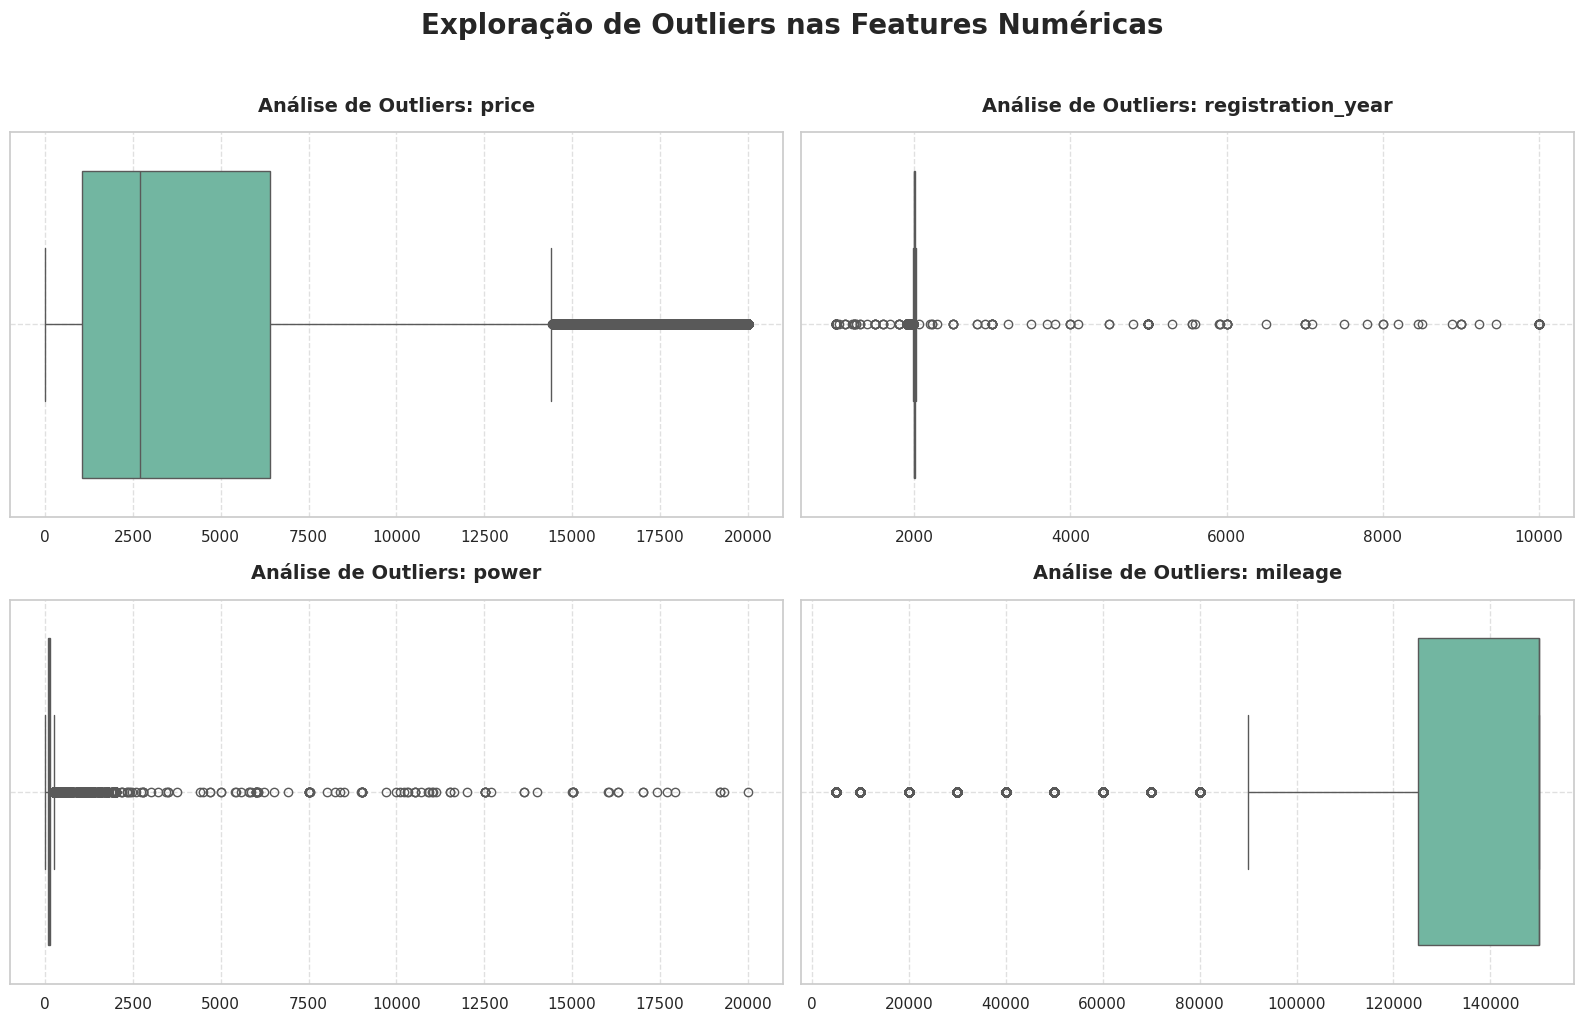

In [151]:

# 1. Lista de colunas numéricas
num_features = ['price', 'registration_year', 'power', 'mileage']

# 2. Configuração da grade (2x2)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()

# 3. Loop com cores vibrantes
for i, col in enumerate(num_features):
    # 'hue' associado ao próprio nome da coluna gera cores diferentes para cada subplot
    sns.boxplot(x=df[col], ax=axes[i], palette='Set2', hue=[col for _ in range(len(df))], legend=False)
    
    # Customização estética
    axes[i].set_title(f'Análise de Outliers: {col}', fontsize=14, fontweight='bold', pad=15)
    axes[i].set_xlabel('')
    axes[i].grid(True, linestyle='--', alpha=0.6) # Grade suave para facilitar a leitura dos valores

# 4. Ajustes de layout
plt.suptitle('Exploração de Outliers nas Features Numéricas', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Correção de inconsistências em váriaveis numéricas:

In [182]:
# ============================================================
# ETAPA: Limpeza dos dados inconsistentes (Data Cleaning) 

# 1. A variavel df_cleaned já foi criada na etapa anterior (categóricos), agora vamos continuar a limpeza dos dados numéricos
# 2. Removendo colunas inúteis (Constantes ou irrelevantes para o preço)
# 'number_of_pictures' é constante (vimos no boxplot/histograma)
# 'postal_code' e datas já removemos da análise, vamos oficializar a saída
cols_to_drop = ['number_of_pictures', 'postal_code', 'date_crawled', 'date_created', 'last_seen']
df_cleaned = df_cleaned.drop(columns=cols_to_drop, errors='ignore')

# 3. Aplicando Filtros (Baseado nos Boxplots)
# Price: Removendo valores simbólicos/zerados
df_cleaned = df_cleaned[df_cleaned['price'] > 100]

# Registration Year: Mantendo carros entre 1980 e 2026
df_cleaned = df_cleaned[(df_cleaned['registration_year'] >= 1980) & (df_cleaned['registration_year'] <= 2026)]

# Power: Mantendo a faixa realista (50 a 600 hp)
df_cleaned = df_cleaned[(df_cleaned['power'] >= 50) & (df_cleaned['power'] <= 600)]

# 4. Verificando o resultado da limpeza
print(f"Registros antes da limpeza: {len(df)}")
print(f"Registros após a limpeza: {len(df_cleaned)}")
print(f"Dados removidos: {len(df) - len(df_cleaned)} ({((len(df) - len(df_cleaned))/len(df))*100:.1f}%)")

# Exibindo o novo resumo estatístico
display(df_cleaned[['price', 'registration_year', 'power', 'mileage']].describe().round(1))

Registros antes da limpeza: 354107
Registros após a limpeza: 297541
Dados removidos: 56566 (16.0%)


,price,registration_year,power,mileage
count,297541.0,297541.0,297541.0,297541.0
mean,4872.1,2003.6,121.9,128805.8
std,4581.7,6.3,53.0,36319.0
min,101.0,1980.0,50.0,5000.0
25%,1399.0,1999.0,80.0,125000.0
50%,3200.0,2004.0,114.0,150000.0
75%,6999.0,2008.0,150.0,150000.0
max,20000.0,2019.0,600.0,150000.0


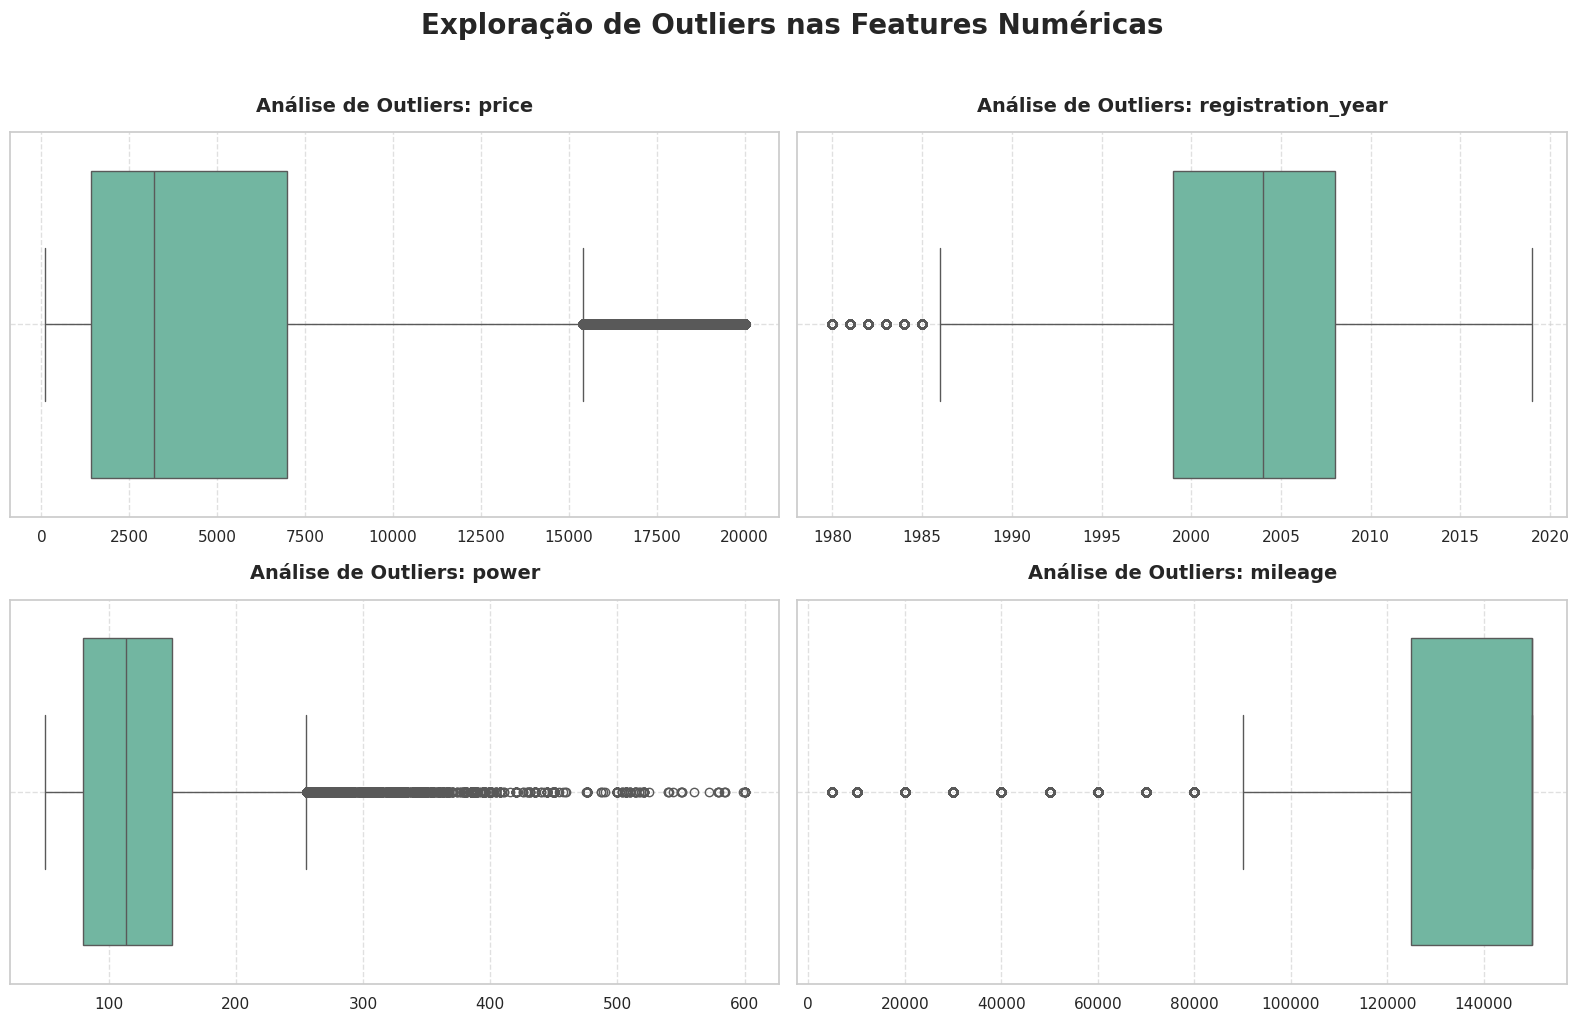

In [153]:
num_features = ['price', 'registration_year', 'power', 'mileage']

# 2. Configuração da grade (2x2)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()

# 3. Loop com cores vibrantes
for i, col in enumerate(num_features):
    # 'hue' associado ao próprio nome da coluna gera cores diferentes para cada subplot
    sns.boxplot(x=df_cleaned[col], ax=axes[i], palette='Set2', hue=[col for _ in range(len(df_cleaned))], legend=False)
    
    # Customização estética
    axes[i].set_title(f'Análise de Outliers: {col}', fontsize=14, fontweight='bold', pad=15)
    axes[i].set_xlabel('')
    axes[i].grid(True, linestyle='--', alpha=0.6) # Grade suave para facilitar a leitura dos valores

# 4. Ajustes de layout
plt.suptitle('Exploração de Outliers nas Features Numéricas', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

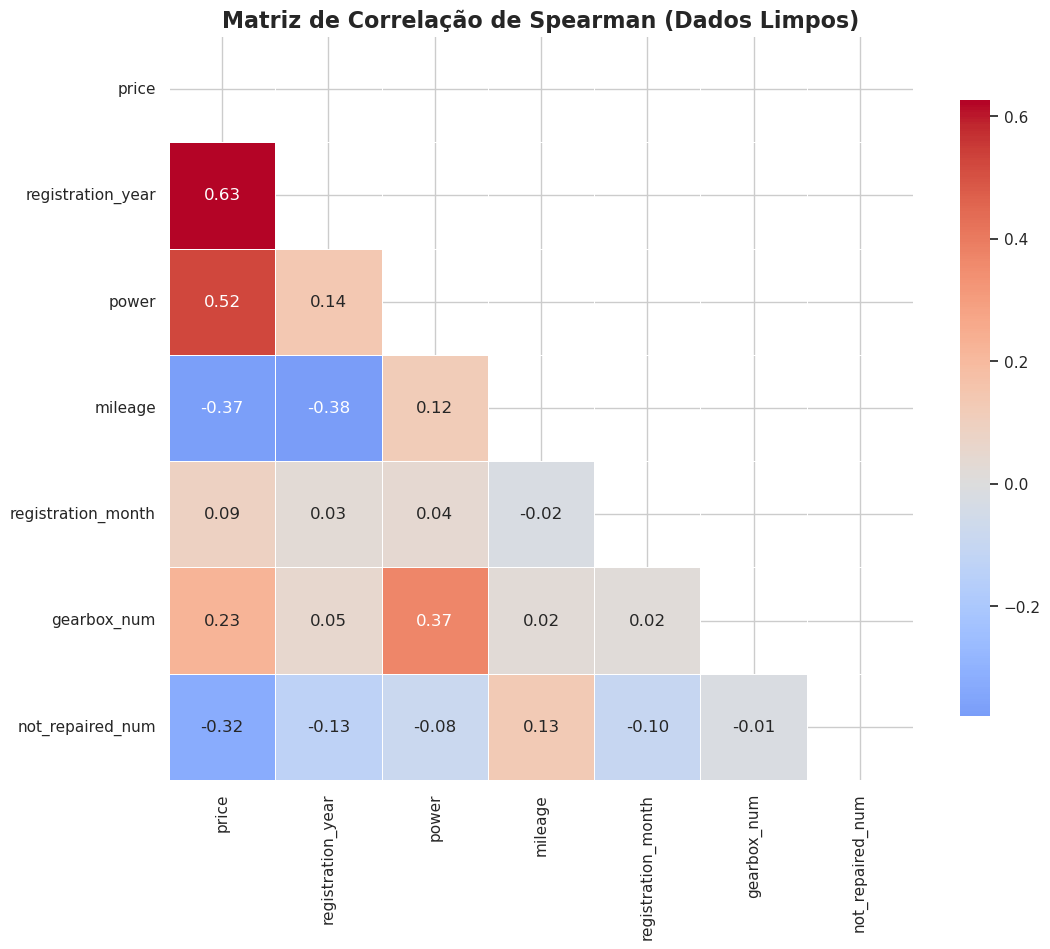

In [185]:

# 1. Criamos uma cópia temporária apenas para a correlação
# Assim não bagunçamos o df_cleaned original com codificações
df_corr = df_cleaned.copy()

# 2. Transformação rápida de categóricas essenciais em números
# Isso nos permite ver essas variáveis no Heatmap
if 'gearbox' in df_corr.columns:
    df_corr['gearbox_num'] = df_corr['gearbox'].map({'manual': 0, 'auto': 1, 'unknown': 0.5})
if 'not_repaired' in df_corr.columns:
    df_corr['not_repaired_num'] = df_corr['not_repaired'].map({'no': 0, 'yes': 1, 'unknown': 0.5})

# 3. Calculamos a correlação de Spearman
# (Melhor que Pearson para capturar relações que não são linhas retas perfeitas)
corr_matrix = df_corr.select_dtypes(include=[np.number]).corr(method='spearman')

# 4. Configuração do gráfico
plt.figure(figsize=(12, 10))

# Criamos uma máscara para esconder a metade superior (redundante)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            mask=mask, 
            cmap='coolwarm', 
            center=0, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .8})

plt.title('Matriz de Correlação de Spearman (Dados Limpos)', fontsize=16, fontweight='bold')
plt.show()

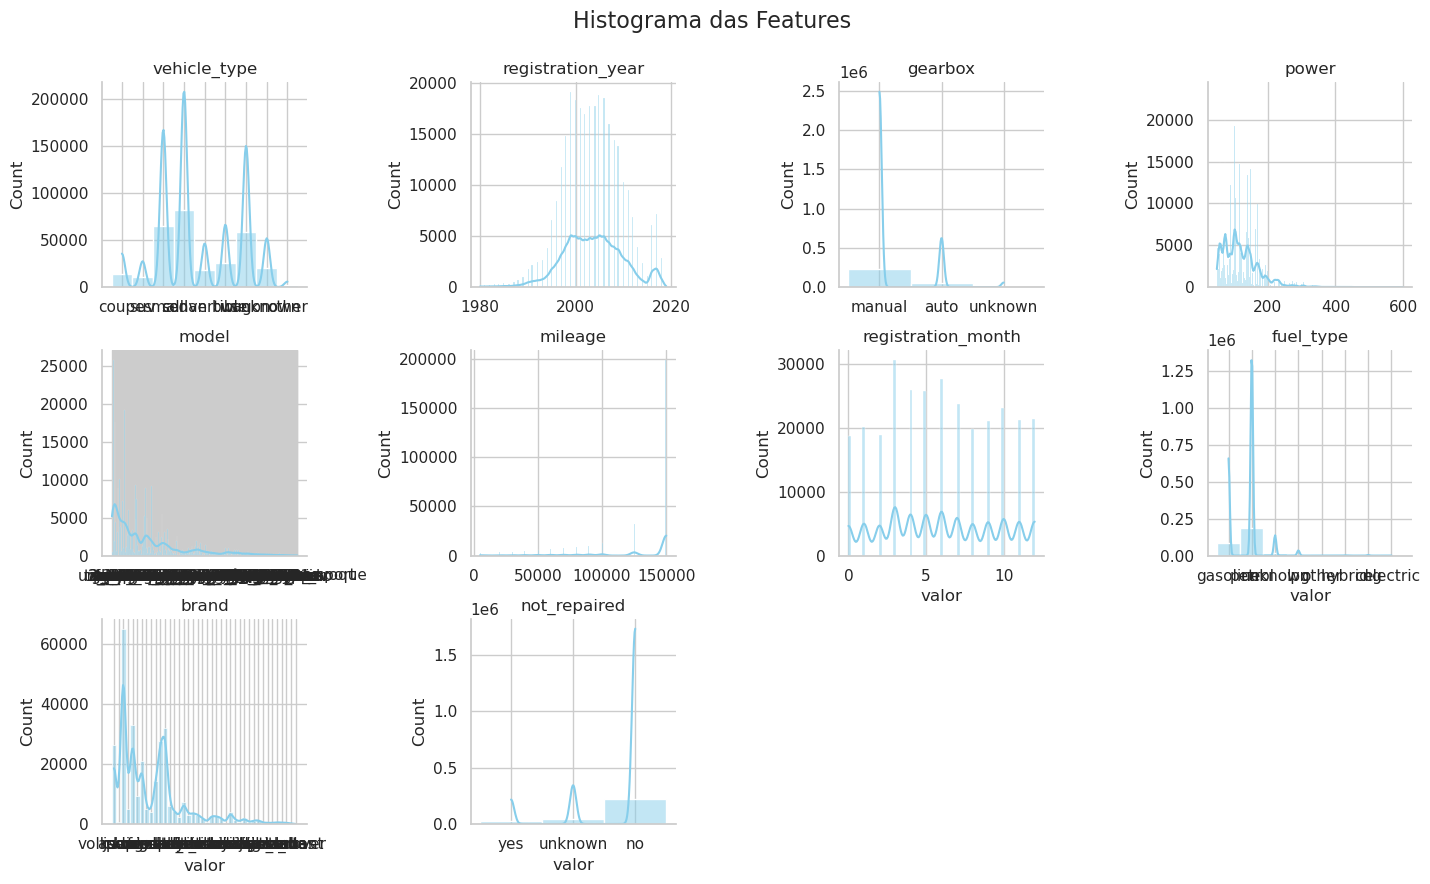

In [184]:
# ============================================================
# Visualização — Histograma de todas as features (Seaborn Edition)
# Objetivo: entender a distribuição de forma leve e eficiente.
# ============================================================

# 1. Selecionamos as colunas de interesse
features_cols = df.columns.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code', 'price', 'number_of_pictures', 'price'])

# 2. Transformamos o DataFrame para o formato "long" (ideal para o Seaborn)
# Isso permite que o Seaborn gerencie a grade de gráficos sozinho.
df_melted = df_cleaned[features_cols].melt(var_name='feature', value_name='valor')

# 3. Criamos a grade de gráficos
# col_wrap=4 define que teremos 4 colunas, pulando para a linha de baixo automaticamente
g = sns.FacetGrid(df_melted, col="feature", col_wrap=4, sharex=False, sharey=False, height=3, aspect=1.2)

# 4. Mapeamos o histograma para cada "quadrado" da grade
g.map(sns.histplot, "valor", kde=True, color='skyblue')

# 5. Ajustes finais de layout
g.set_titles("{col_name}") # Define o nome da coluna como título de cada gráfico
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Histograma das Features', fontsize=16)

plt.show()

## Treinamento do modelo

## Análise do modelo

# Checklist

Digite 'x' para verificar. Em seguida, pressione Shift + Enter.

- [x]  O Jupyter Notebook está aberto
- [ ]  O código está livre de erros
- [ ]  As células com o código foram organizadas em ordem de execução
- [ ]  Os dados foram baixados e preparados
- [ ]  Os modelos foram treinados
- [ ]  A análise de velocidade e qualidade dos modelos foi realizada